# LETOR Test


In [38]:
from collections import Counter
import itertools
import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model, cross_validation
%matplotlib inline

##Intuition

- Start with a simulated example, assume the ranking of return for a query is $\{0,1,2\}$, below plot shows return groups for two queries ($\bigcirc$, and $\triangle$). 0 is white, blue is 1 and black is 2
- The order between documents/plans can be obtained by projecting the points on direction $w$

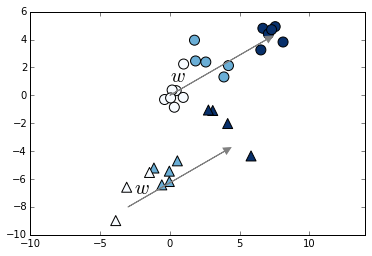

In [39]:
np.random.seed(0)
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)])
K = 20
X = np.random.randn(K, 2)
y = [0] * K
for i in range(1, 3):
    X = np.concatenate((X, np.random.randn(K, 2) + i * 4 * w))
    y = np.concatenate((y, [i] * K))

# slightly displace data corresponding to our second partition
X[::2] -= np.array([3, 7]) 
blocks = np.array([0, 1] * (X.shape[0] / 2))

# split into train and test set
cv = cross_validation.StratifiedShuffleSplit(y, test_size=.5)
train, test = iter(cv).next()
X_train, y_train, b_train = X[train], y[train], blocks[train]
X_test, y_test, b_test = X[test], y[test], blocks[test]

# plot the result
idx = (b_train == 0)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(0, 1, '$w$', fontsize=20)
pl.arrow(-3, -8, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(-2.6, -7, '$w$', fontsize=20)
pl.axis('equal')
pl.show()

- If we just train a linear model directly with this data, the $w$ vector would be in the direction below:

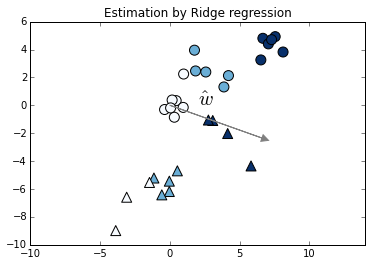

In [41]:
ridge = linear_model.Ridge(1.)
ridge.fit(X_train, y_train)
coef = ridge.coef_ / np.linalg.norm(ridge.coef_)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
    head_width=0.5, head_length=0.5)
pl.text(2, 0, '$\hat{w}$', fontsize=20)
pl.axis('equal')
pl.title('Estimation by Ridge regression')
pl.show()

- and the [Kendall tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) for the test data is:

In [42]:
for i in range(2):
    tau, _ = stats.kendalltau(
        ridge.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.71122
Kendall correlation coefficient for block 1: 0.84387


- the reason this apporach doesn't work well is the difference between intergroup samples cannot always provide correct information on the ranking. 
- for example, the offset between blue and black triangles are similar with that between black triangles and circles, yet the former offset indicates a ranking difference while the later should't (and it just adds noise to the data).
- to avoid that, we need to **normalize/transform** the data in some way such that all features are consistantly representing the ranking difference within the samples
- pairwise difference between samples with _different_ label _within_ a query return group just does that, specifically the pairwise feature can be generated as: $(x_k',y_k')=(x_i−x_j,sign(y_i−y_j))$, as shown below:

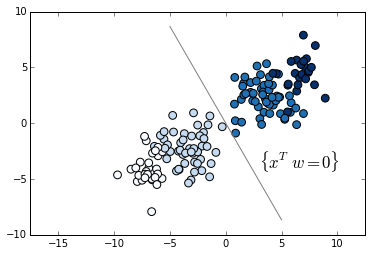

In [43]:
# form all pairwise combinations
comb = itertools.combinations(range(X_train.shape[0]), 2)
k = 0
Xp, yp, diff = [], [], []
for (i, j) in comb:
    if y_train[i] == y_train[j] \
        or blocks[train][i] != blocks[train][j]:
        # skip if same target or different group
        continue
    Xp.append(X_train[i] - X_train[j])
    diff.append(y_train[i] - y_train[j])
    yp.append(np.sign(diff[-1]))
    # output balanced classes --> it is an equivalent training point when both x and y reserver their signs
    if yp[-1] != (-1) ** k:
        yp[-1] *= -1
        Xp[-1] *= -1
        diff[-1] *= -1
    k += 1
Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))
pl.scatter(Xp[:, 0], Xp[:, 1], c=diff, s=60, marker='o', cmap=pl.cm.Blues)
x_space = np.linspace(-10, 10)
pl.plot(x_space * w[1], - x_space * w[0], color='gray')
pl.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
pl.axis('equal')
pl.show()

- now we can apply a SVM model on the data to obtain the direction $w$, 
- and this algrithm is **RankSVM** when input feature are processed pairwise

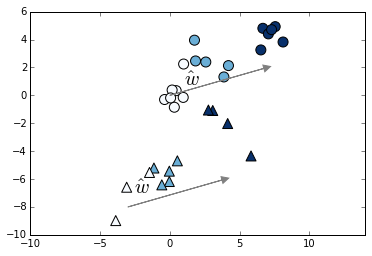

In [45]:
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(Xp, yp)
coef = clf.coef_.ravel() / np.linalg.norm(clf.coef_)
pl.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx],
    marker='^', cmap=pl.cm.Blues, s=100)
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx],
    marker='o', cmap=pl.cm.Blues, s=100)
pl.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray',
    head_width=0.5, head_length=0.5)
pl.arrow(-3, -8, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray',
    head_width=0.5, head_length=0.5)
pl.text(1, .7, '$\hat{w}$', fontsize=20)
pl.text(-2.6, -7, '$\hat{w}$', fontsize=20)
pl.axis('equal')
pl.show()

- we can see the $w$ given by SVM is much closer than the original one
- and the Kendall tau is improved as well, especially for group 0, which previously has a tau of **0.71122**

In [46]:
for i in range(2):
    tau, _ = stats.kendalltau(
        np.dot(X_test[b_test == i], coef), y_test[b_test == i])
    print('Kendall correlation coefficient for block %s: %.5f' % (i, tau))

Kendall correlation coefficient for block 0: 0.83627
Kendall correlation coefficient for block 1: 0.84387


##Apply RankSVM on LETOR sample data
- *sample:* '0 qid:10 1:0.039477 2:0.000000 3:0.750000 4:0.166667 5:0.040555 6:0.000000 7:0.000000 8:0.000000 9:0.000000 10:0.000000 11:0.036178 12:0.000000 13:0.751573 14:0.175557 15:0.039086 16:0.053319 17:0.187500 18:1.000000 19:0.111111 20:0.053668 21:0.605907 22:0.469614 23:0.827181 24:0.582661 25:0.000000 26:0.000000 27:0.000000 28:0.000000 29:0.266984 30:0.204123 31:0.323377 32:0.176450 33:0.287760 34:0.074987 35:0.002373 36:0.052280 37:0.565875 38:0.569440 39:0.769845 40:0.646567 41:0.073711 42:0.076923 43:0.034483 44:0.333333 45:0.218391 46:0.000000 #docid = GX037-87-3082362 inc = 0.588907390055858 prob = 0.3348'
- 1st column is relevancy index, 2nd is query ID, followed by 46 features, and some doc info at last. Details can be found [here](http://arxiv.org/ftp/arxiv/papers/1306/1306.2597.pdf).
- for each query, there are a group of documents associated as return. 
- similar to the simulation above, the pairwise feature will be extract based on the difference between doc _within_ the group with _different_ relavancy factor.

In [19]:
# a tiny class to hold raw data
class rankFeature:
    
    def __init__(self, query, rel, fea):
        self.qid, self.relevancy, self.featureVector = query, rel, np.array(fea)
    
# parse each line of file into rankFeature class
def parseFeature(line):
    elem = line.replace(' = ', '=').split()
    fv = [float(fea.split(':')[1]) for fea in elem[2:48]]
    return rankFeature(elem[1].split(':')[1], int(elem[0]), fv)

# generate pairwise feature set with the documents/plans returned for one query
def pairFeature(featureGroup):
    size = len(featureGroup)
#     print 'DEBUG: input size: %d' %size
    comb = itertools.combinations(range(size), 2)
    x, y, diff = [], [], []
    k = 0
    for i,j in comb:
        r_diff = featureGroup[i].relevancy - featureGroup[j].relevancy
        if r_diff == 0:
            continue
        x.append(featureGroup[i].featureVector - featureGroup[j].featureVector)        
        diff.append(r_diff)
        y.append(np.sign(r_diff))
        
        # balance the data
        if y[-1] != (-1) ** k:
            y[-1] *= -1
            x[-1] *= -1
            diff[-1] *= -1
        k += 1
        
    return map(np.array, (x, y))

# assemble training data from raw input
def getTrainingData(data, nQuery=0):
    X_set, Y_set = [], []
    n = 0
    for grp in itertools.groupby(data, lambda s: s.qid):
        features = list(grp[1])
        nRel = Counter([x.relevancy for x in features])
        if len(nRel) > 1:
            x, y = pairFeature(features)
#         print 'DEBUG: query %s (%s) generates %d features, with %d +1.' %(grp[0], str(nRel), len(y), sum(y==1))
            X_set.extend(x)
            Y_set.extend(y)
            n += 1
        if n == nQuery and nQuery > 0:
            break
            
    return map(np.array, (X_set, Y_set))

###Load training data
- due to resource limitation, we only use data from a limited number of query for training
- train SVM with linear kernel

In [47]:
# load training data
with open('train.txt') as f:
    X_train = [parseFeature(l) for l in f.readlines()]
    
# generate training set, put 0 to include all data for training
x_train, y_train = getTrainingData(X_train, 100)
print 'Training data size: %d' %len(y_train)

# train a SVM classifier
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(x_train, y_train)


Training data size: 27231


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

###Load test data, and evaluate Kendall tau
- with training data from 10 queries, tau = 0.096
- with training data from 100 queries, tau = 0.188

In [49]:
# load test data
with open ('test.txt') as f:
    X_test = [parseFeature(l) for l in f.readlines()]


In [50]:
# check Kendall's tau on test data set
coef = clf.coef_.ravel() / np.linalg.norm(clf.coef_)
stats.kendalltau(np.dot([x.featureVector for x in X_test], coef), [x.relevancy for x in X_test])

(0.18804182114238852, 3.8975501624141524e-238)